# Source Convergence

In this session, we demonstrate how to look at source convergence via a metric called Shannon entropy. Shannon entropy is a concept from information theory that characterizes how much "information" a bit stream stores. In the context of eigenvalue calculations, it has been shown that when a source distibution is discretized over a mesh, the entropy of the source probability converges as the distribution itself reaches stationarity.

Shannon entropy is defined as

$$ H = - \sum_i p_i \log_2 p_i $$

where $p_i$ is the fraction of source particles in mesh cell $i$. The `Settings` object in OpenMC allows us to specify a mesh over which entropy should be calculated. Note that unlike MCNP, the entropy is not automatically calculated otherwise.

In [1]:
%matplotlib inline
import openmc
import numpy as np
import matplotlib.pyplot as plt

In this notebook, rather than laboriously constructing inputs, we're going to use pre-generated inputs. A few classes have been defined in a script `inputs.py` that we will import. It is in a subdirectory, so we have to tell Python (via `sys.path`) that we want to be able to import modules from there.

In [2]:
import sys
sys.path.append('../..')
from inputs import *

The script defines three classes `CoreInputSet`, `AssemblyInputSet`, and `PinCellInputSet`. Each of these classes has `geometry`, `materials`, and `settings` attributes as well as an `export()` method that writes all the XML files. Let's create the core (which is based on the [OECD/NEA Performance Benchmark](https://www.oecd-nea.org/dbprog/documents/MonteCarlobenchmarkguideline_004.pdf)) model and export it to XML.

In [3]:
core = CoreInputSet()
core.export()

We'll use the nifty `Plot.from_geometry` method to get a quick plot of the core. Note that you need to use a high resolution or else the plot will look weird.

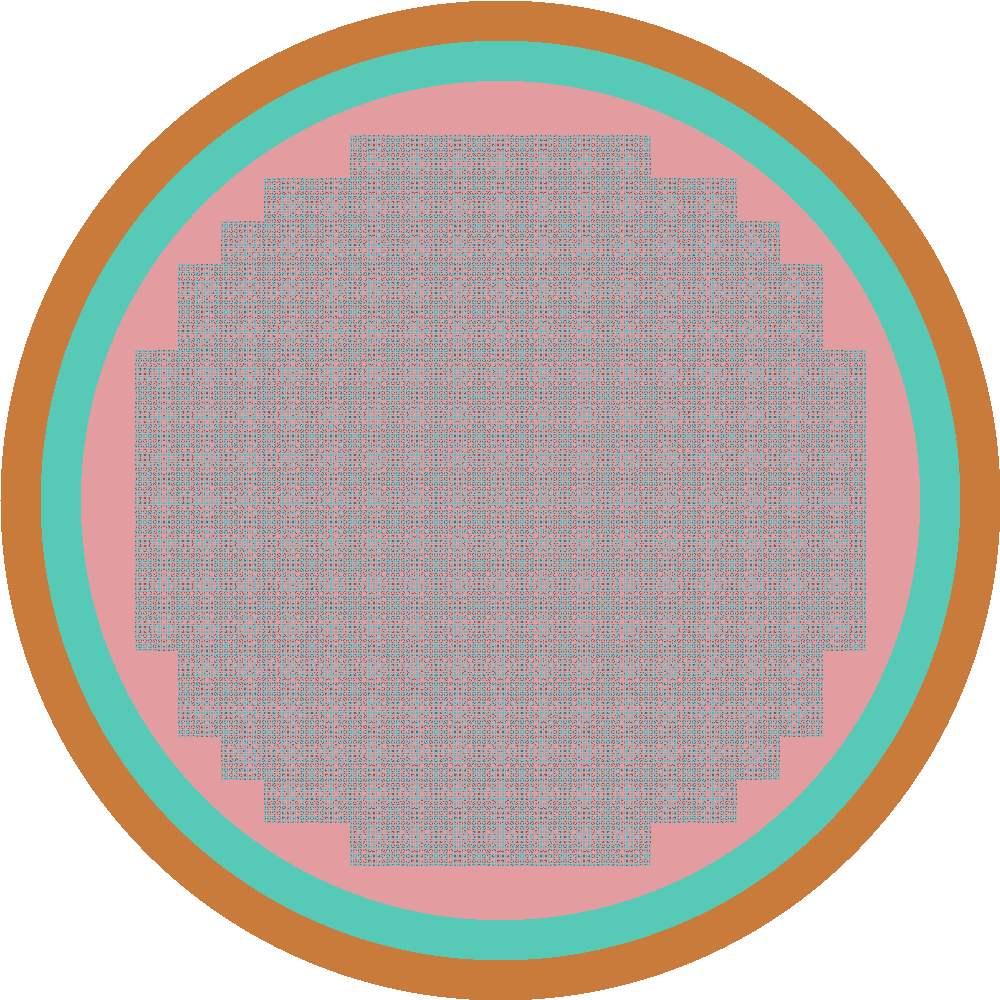

In [4]:
p = openmc.Plot.from_geometry(core.geometry)
p.color_by = 'material'
p.pixels = (1000, 1000)
openmc.plot_inline(p)

Ok, let's get down to business now. We'll need to create a `Mesh` object that will be used to count source particles over and calculate Shannon entropy. We'll take advantage of the fact that `Geometry` can tell us its bounding box, which we're going to use as the lower-left and upper-right coordinates of the mesh. Finally we'll make the mesh itself 10x10x10.

In [5]:
entropy_mesh = openmc.Mesh()
entropy_mesh.lower_left, entropy_mesh.upper_right = \
    core.geometry.bounding_box
entropy_mesh.dimension = (10, 10, 10)
entropy_mesh

Mesh
	ID             =	10000
	Name           =	
	Type           =	regular
	Basis          =	(10, 10, 10)
	Width          =	[-249. -249. -229.]
	Origin         =	[ 249.  249.  223.]
	Pixels         =	None

Now let's assign it to the `Settings` object, re-export the file, and run OpenMC.

In [6]:
core.settings.entropy_mesh = entropy_mesh
core.settings.export_to_xml()
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

Great! We can see in the standard out that entropy was calculated. Now we'd like to see what it actually looks like to decide if we skipped enough generations. First, how many generations did we skip?

In [7]:
core.settings.inactive

50

Ok, so we want to make sure our entropy is settled by generation 50. Let's plot it from the statepoint file.

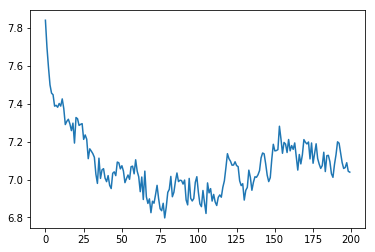

In [8]:
sp = openmc.StatePoint('statepoint.200.h5')
plt.plot(range(sp.n_batches), sp.entropy)

It looks like we were justified by discarded 50 batches, but it's not clear because the entropy jumps around a lot. We can make it smoother by running more particles per generation.

In [9]:
core.settings.particles

1000

Let's bump up the number of particles per generation by a factor of 10 and re-run OpenMC.

In [10]:
core.settings.particles = 10000
core.settings.export_to_xml()
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

And now plot the entropy once again:

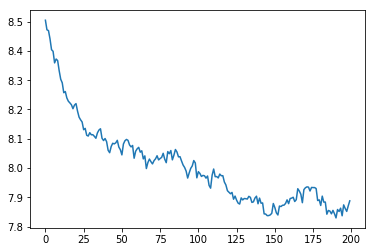

In [11]:
sp = openmc.StatePoint('statepoint.200.h5')
plt.plot(range(sp.n_batches), sp.entropy)

It seems clearer now when we ran with 10,000 particles per generation that we're probably not discarding enough generations to begin with!